🚀 Transformer モデルの学習を開始します...
Epoch 1/50
482/482 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.1264 - loss: 2.3011 - val_accuracy: 0.2135 - val_loss: 2.2584
Epoch 2/50
482/482 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.1996 - loss: 2.2497 - val_accuracy: 0.2669 - val_loss: 2.2004
Epoch 3/50
482/482 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.2366 - loss: 2.1911 - val_accuracy: 0.2983 - val_loss: 2.1334
Epoch 4/50
482/482 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.2644 - loss: 2.1251 - val_accuracy: 0.3266 - val_loss: 2.0670
Epoch 5/50
482/482 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.2792 - loss: 2.0655 - val_accuracy: 0.3326 - val_loss: 2.0080
Epoch 6/50
482/482 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.2854 - loss: 2.0195 - val_accuracy: 0.3401 - val_loss: 1.9615
Epoch 7/50
482/482 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.3038 - loss: 1.9779 - val_accuracy: 0.3507 - val_loss: 1.9218
Epoch 8/50
482/482 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0

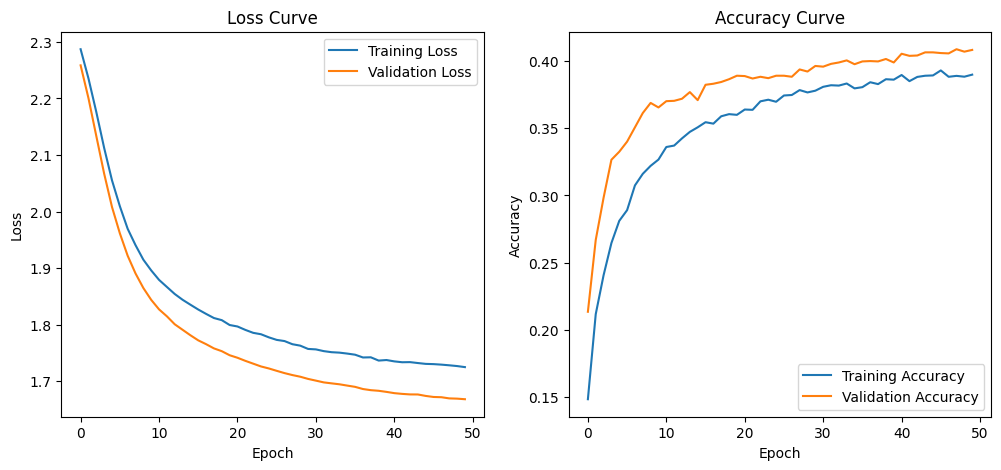

✅ Transformer モデルの学習が完了しました。
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3920 - loss: 1.7098 
Test Loss: 1.6937
Test Accuracy: 0.3990


In [18]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 🚀 TensorFlow の OneDNN 最適化を無効化
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

# 🚀 データ保存先
DATA_DIR = "./data/"

# 🚀 データのロード
X_train = np.load(os.path.join(DATA_DIR, "X_train.npy"))
y_train = np.load(os.path.join(DATA_DIR, "y_train.npy"))
X_val = np.load(os.path.join(DATA_DIR, "X_val.npy"))
y_val = np.load(os.path.join(DATA_DIR, "y_val.npy"))
X_test = np.load(os.path.join(DATA_DIR, "X_test.npy"))
y_test = np.load(os.path.join(DATA_DIR, "y_test.npy"))

# 🚀 データの正規化（Min-Max スケーリング）
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# 🚀 Transformer に適したデータ形状に変換
sequence_length = X_train.shape[1]
feature_dim = 1  # 特徴量の次元
X_train = X_train.reshape((X_train.shape[0], sequence_length, feature_dim))
X_val = X_val.reshape((X_val.shape[0], sequence_length, feature_dim))
X_test = X_test.reshape((X_test.shape[0], sequence_length, feature_dim))

# 🚀 Transformer の構築
def transformer_encoder(inputs, head_size=64, num_heads=2, ff_dim=64, dropout=0.1):
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    x = Dense(ff_dim, activation="relu")(res)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    return x + res

inputs = Input(shape=(sequence_length, feature_dim))
x = transformer_encoder(inputs)
x = transformer_encoder(x)
x = Flatten()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.3)(x)
outputs = Dense(y_train.shape[1], activation="softmax")(x)

model = Model(inputs, outputs)

# 🚀 モデルのコンパイル
model.compile(optimizer=Adam(learning_rate=0.0003), loss="categorical_crossentropy", metrics=["accuracy"])

# 🚀 EarlyStopping の設定
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

# 🚀 モデルの学習
print("🚀 Transformer モデルの学習を開始します...")
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)
print("✅ Transformer モデルの学習が完了しました。")

# 🚀 学習曲線の可視化
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")
plt.show()

# 🚀 モデルの保存
model.save(os.path.join(DATA_DIR, "transformer_model.keras"))
print("✅ Transformer モデルの学習が完了しました。")

# 🚀 モデルの評価
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
